In [288]:
import numpy as np
import pandas as pd
import pulp
import itertools
import folium
import openrouteservice
from geopy.distance import great_circle
from geopy.geocoders import Nominatim
from branca.element import Figure
from openrouteservice import convert

zahyo = pd.read_csv("geo_loc_pos.csv")
idou_jikan = pd.read_csv("geo_loc_loc_time.csv")

customer_count = len(zahyo) #顧客数（id=0はdepot）
vehicle_count = 100000 #idou_jikan
vehicle_capacity = 60*60 #一日に使える時間

In [289]:
#顧客緯度・経度設定
df = pd.DataFrame(zahyo.drop("地名",axis=1))

print(df)

          緯度          経度
0  35.631040  139.786485
1  35.629763  139.793982
2  35.649380  139.789728
3  35.619614  139.776940
4  35.632654  139.792974
5  35.635271  139.780359


In [297]:
dist = [[great_circle((df.loc[i,'緯度'],df.loc[i,'経度']), 
                      (df.loc[j,'緯度'],df.loc[j,'経度'])).meters 
         if i != j else 0 for j in range(0,customer_count)] for i in range(0,customer_count)]
cost=np.array(dist)

<Axes: >

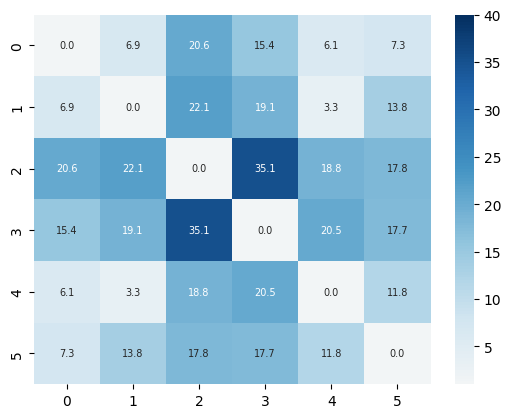

In [296]:
import seaborn as sns

sns.heatmap(cost/100, vmax=40, vmin=1, center=0, cmap='RdBu', annot=True, annot_kws={"size": 7},fmt=".1f")

In [292]:
count_num = 0

for vehicle_count in range(1,vehicle_count+1):
      problem = pulp.LpProblem("CVRP", pulp.LpMinimize)
      x = [[[pulp.LpVariable("x%s_%s,%s"%(i,j,k), cat="Binary") if i != j else None for k in range(vehicle_count)]\
          for j in range(customer_count)] for i in range(customer_count)]

      problem += pulp.lpSum(cost[i][j] * x[i][j][k] if i != j else 0
                            for k in range(vehicle_count) for j in range(customer_count) for i in range (customer_count))

      for j in range(1, customer_count):
          problem += pulp.lpSum(x[i][j][k] if i != j else 0 for i in range(customer_count) for k in range(vehicle_count)) == 1 

      for k in range(vehicle_count):
          problem += pulp.lpSum(x[0][j][k] for j in range(1,customer_count)) == 1
          problem += pulp.lpSum(x[i][0][k] for i in range(1,customer_count)) == 1

      for k in range(vehicle_count):
          for j in range(customer_count):
              problem += pulp.lpSum(x[i][j][k] if i != j else 0 for i in range(customer_count)) -  pulp.lpSum(x[j][i][k] for i in range(customer_count)) == 0
      for k in range(vehicle_count):
          problem += pulp.lpSum(cost[i][j] * x[i][j][k] if i != j else 0 for i in range(customer_count) for j in range (1,customer_count)) <= vehicle_capacity 
      
      subtours = []
      for i in range(2,customer_count):
          subtours += itertools.combinations(range(1,customer_count), i)
      for s in subtours:
          problem += pulp.lpSum(x[i][j][k] if i !=j else 0 for i, j in itertools.permutations(s,2) for k in range(vehicle_count)) <= len(s) - 1
      
      if problem.solve() == 1:
          print('車両数:', vehicle_count)
          print('目的関数値:', pulp.value(problem.objective))
          break

車両数: 2
目的関数値: 8962.031651246161


In [293]:
color_list = ["red","green","purple","orange","darkred","lightred","beige","darkblue","darkgreen","cadetblue","darkpurple","white","pink","lightblue","lightgreen","gray","black","lightgray","blue"]
 
points_a = []
for i in range(len(zahyo)):
    points_a.append([zahyo.iloc[i,1],zahyo.iloc[i,2]])

In [294]:
ave_lat = sum(p[0] for p in points_a)/len(points_a)
ave_lon = sum(p[1] for p in points_a)/len(points_a)
fig = Figure(width=800, height=400)

my_map = folium.Map(
    location=[ave_lat, ave_lon], 
    zoom_start=13
)

list_1 = []
list_2 = []

for k in range(vehicle_count):
    for bangou_2 in range(customer_count):
        for j in range(customer_count):
            if bangou_2 != j and pulp.value(x[bangou_2][j][k]) == 1:
                #print("日付：",k)
                #print("地点：",bangou_2)
                #print("目的：",j,"\n")
                list_1.append(bangou_2)
                list_2.append(k)
                
print(list_1,list_2)
list_3 = []
count_dayo = 0
bangou_1 = 0

for aaaa in list_2:
    bangou_2 = list_1[bangou_1]
    if not(aaaa==count_dayo):
        list_3.append([zahyo.iloc[0,1],zahyo.iloc[0,2]])
        folium.PolyLine(list_3, 
                        color=color_list[aaaa], 
                        weight=2.5, 
                        opacity=1
                        ).add_to(my_map)
        for each in range(len(list_3)-2):
            folium.Marker(
                    location=list_3[each+1],
                    icon = folium.Icon(color=color_list[aaaa])
                ).add_to(my_map)
        list_3 = []
        list_3.append([zahyo.iloc[bangou_2,1],zahyo.iloc[bangou_2,2]])
        count_dayo += 1
    else:
        list_3.append([zahyo.iloc[bangou_2,1],zahyo.iloc[bangou_2,2]])
    bangou_1 += 1
list_3.append([zahyo.iloc[0,1],zahyo.iloc[0,2]])
folium.PolyLine(list_3, 
                color=color_list[0], 
                weight=2.5, 
                opacity=1
                ).add_to(my_map)
for each in range(len(list_3)-2):
    folium.Marker(
            location=list_3[each+1],
            icon = folium.Icon(color=color_list[0])
        ).add_to(my_map)


# add markers 'nomal'
folium.Marker(
    location=[zahyo.iloc[0,1],zahyo.iloc[0,2]],
    popup=zahyo.iloc[0,0]
).add_to(my_map)

    
 
fig.add_child(my_map)

[0, 2, 5, 0, 1, 3, 4] [0, 0, 0, 1, 1, 1, 1]
